In [1]:
# DCGANでmnistの手書き文字を生成する
# 必要なライブラリをインポート（torchを利用）
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import make_grid

In [2]:
# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# MNISTデータをダウンロード
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=64, shuffle=True)

In [23]:
# モデルの定義
class Generator(nn.Module):
    def __init__(self, z_dim=100, image_size=28*28):
        super().__init__()
        self.deconv1 = self.decode_layers(z_dim, 512, 3, 1, 0)
        self.deconv2 = self.decode_layers(512, 256, 3, 2, 0)
        self.deconv3 = self.decode_layers(256, 128, 4, 2, 1)
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(128, 1, 4, 2, 1),
            nn.Tanh()
        )

    def decode_layers(self, in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        return net

    def forward(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, image_size=28*28):
        super(Discriminator, self).__init__()
        self.conv1 = self.encode_layers(1, 128, 4, 2, 1)
        self.conv2 = self.encode_layers(128, 256, 4, 2, 1)
        self.conv3 = self.encode_layers(256, 512, 3, 2, 0)
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 1, 3, 1, 0),
            nn.Sigmoid()
        )
    
    def encode_layers(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        return net

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

In [24]:
# モデルのインスタンスを生成
z_dim = 100
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

# GPUが使える場合はモデルをGPUに載せる
G.to(device)
D.to(device)

# 損失関数の定義
criterion = nn.BCELoss()

# 最適化手法の定義
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

損失関数

$ L(D, G) = \mathbb{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[\log(1 - D(G(z)))]$

In [28]:
# モデルの学習(GPUを使う場合は、モデルとデータをGPUに載せる)
n_epoch = 10
D_loss_list = []
G_loss_list = []


for epoch in range(n_epoch):
    D_loss_sum = 0.0
    G_loss_sum = 0.0
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        real_images = real_images.to(device)
        fake_images = G(noise)
        real_labels = torch.ones(batch_size, 1, 1, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1, 1, 1).to(device)
        # Discriminatorの更新
        d_optimizer.zero_grad()
        real_outputs = D(real_images)
        fake_outputs = D(fake_images)
        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        D_loss_sum += d_loss.item()
        # Generatorの更新
        g_optimizer.zero_grad()
        fake_images = G(noise)
        fake_outputs = D(fake_images)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()
        G_loss_sum += g_loss.item()
        
    D_loss_sum /= len(dataloader)
    G_loss_sum /= len(dataloader)
    D_loss_list.append(D_loss_sum)
    G_loss_list.append(G_loss_sum)
    print('epoch[%d/%d] D_loss: %.3f, G_loss: %.3f' % (epoch+1, n_epoch, D_loss_sum, G_loss_sum))

epoch[1/10] D_loss: 0.019, G_loss: 8.664
epoch[2/10] D_loss: 0.067, G_loss: 6.808
epoch[3/10] D_loss: 0.192, G_loss: 5.403
epoch[4/10] D_loss: 0.344, G_loss: 3.637
epoch[5/10] D_loss: 0.442, G_loss: 3.057
epoch[6/10] D_loss: 0.462, G_loss: 2.833
epoch[7/10] D_loss: 0.517, G_loss: 2.661
epoch[8/10] D_loss: 0.549, G_loss: 2.520
epoch[9/10] D_loss: 0.563, G_loss: 2.414
epoch[10/10] D_loss: 0.578, G_loss: 2.356


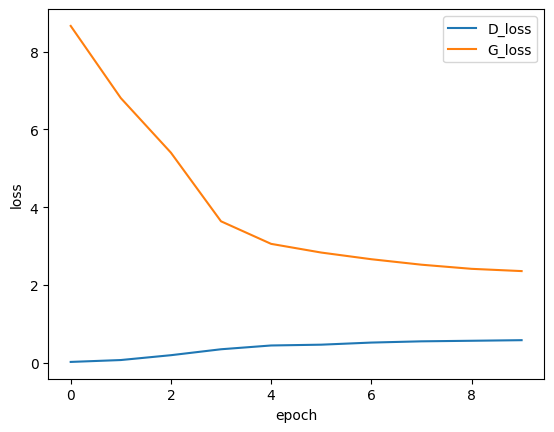

In [31]:
# 損失関数の推移をグラフで表示
plt.plot(D_loss_list, label='D_loss')
plt.plot(G_loss_list, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

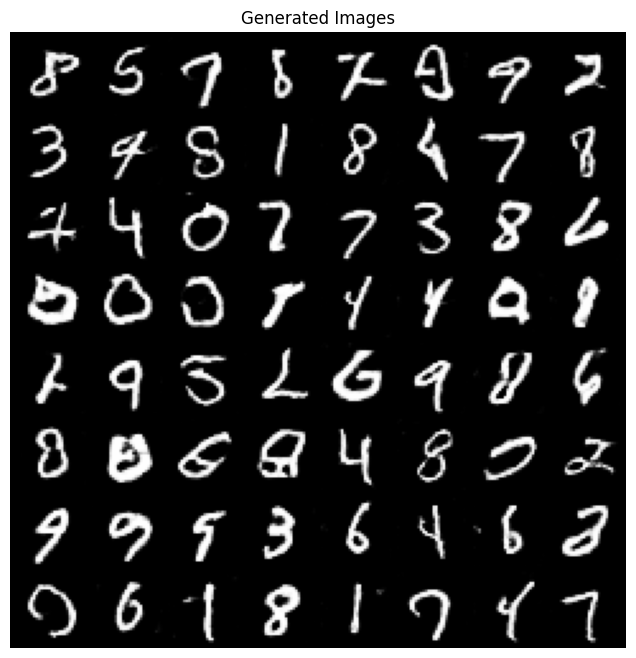

In [30]:
# 生成画像を表示
G.eval()
noise = torch.randn(64, z_dim, 1, 1).to(device)
fake_images = G(noise)
fake_images = fake_images.view(-1, 1, 28, 28)
fake_images = fake_images.cpu().detach()
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()
